# Librerias

In [1]:
%config IPCompleter.greedy=True
import numpy as np
from time import perf_counter
import matplotlib.pyplot as plt
plt.style.use('dark_background')

#Librosa
from librosa import lpc
from librosa.effects import preemphasis
from librosa import resample
from librosa.util import peak_pick
from librosa.util import frame
from librosa import load

#Scipy
from scipy import spatial

# Tablas de vocales y consonantes

In [2]:
male_vowel_dict = {
    " ": (0, 0),
    "i": (240, 2400),
    "y": (235, 2100),
    "e": (390, 2300),
    "ø": (370, 1900),
    "ɛ": (610, 1900),
    "œ": (585, 1710),
    "a": (850, 1610),
    "ɶ": (820, 1530),
    "ɑ": (750, 940),
    "ɒ": (700, 760),
    "ʌ": (600, 1170),
    "ɔ": (500, 700),
    "ɤ": (460, 1310),
    "o": (360, 640),
    "w": (300, 1390),
    "u": (250, 595)
}

male_vowel_inv_dict = {
    (0, 0): " ",
    (240, 2400): "i",
    (235, 2100): "y",
    (390, 2300): "e",
    (370, 1900): "ø",
    (610, 1900): "ɛ",
    (585, 1710): "œ",
    (850, 1610): "a",
    (820, 1530): "ɶ",
    (750, 940): "ɑ",
    (700, 760): "ɒ",
    (600, 1170): "ʌ",
    (500, 700): "ɔ",
    (460, 1310): "ɤ",
    (360, 640): "o",
    (300, 1390): "w",
    (250, 595): "u"
}

male_vowel_array = [
    (0, 0),
    (240, 2400),
    (235, 2100),
    (390, 2300),
    (370, 1900),
    (610, 1900),
    (585, 1710),
    (850, 1610),
    (820, 1530),
    (750, 940),
    (700, 760),
    (600, 1170),
    (500, 700),
    (460, 1310),
    (360, 640),
    (300, 1390),
    (250, 595)
]

# Funciones

In [3]:
NUMBER_OF_SLOTS = 4
time_taken = []

def Peaks2Formants(peaks, spectrum, estimates):
    slot = np.zeros(NUMBER_OF_SLOTS, dtype=int) #Slots where potential formants are placed
    used_indx = []
    #STEP 1 - fill slots based on closest distance to estimates
    for i in range(0, NUMBER_OF_SLOTS):
        indx = np.argmin( abs(peaks-estimates[i]) )
        slot[i] = peaks[indx] 
        used_indx.append(indx)
        
    #STEP 2 - remove duplicates
    u, indices = np.unique(slot, return_index=True)
    for i in range(0, NUMBER_OF_SLOTS):
        if i not in  indices:
            slot[i] = 0
    
    #STEP 3 - deal with unused peaks
    unused_peaks = np.delete(peaks,used_indx)
    if len(unused_peaks) > 0:
        for peak in unused_peaks:
            k = np.argmin(peaks - peak)
            if slot[k] == 0: # Si el slot con el mismo numero esta vacio lo asigno ahi
                slot[k] = peak
            elif spectrum[int(peak)] > 0.5*spectrum[slot[k]]:
                if k < NUMBER_OF_SLOTS:
                    if slot[k+1] == 0: 
                        slot[k+1] = slot[k] #Muevo el pico del slot uno para adelante
                        slot[k] = peak #Asigno el pico sin usar al slot con su numero
                    else:
                        if k > 0:
                            if slot[k-1] == 0: 
                                slot[k-1] = slot[k] #Muevo el pico del slot uno para atras
                                slot[k] = peak #Asigno el pico sin usar al slot con su numero
    slot.sort()
    return slot
    
def GetFormants(buffer, fs, estimates, energy_th=5e-3, N=252, new_fs=1e4, lpc_order=14):
    if( buffer.std() < energy_th ):
        return np.zeros(NUMBER_OF_SLOTS), estimates #Descarto el frame si es silencio
    start_time = perf_counter()
    hp_filtered = preemphasis(buffer, coef=1)
    downsampled = resample(hp_filtered, fs, new_fs)
    coefs = lpc(downsampled, lpc_order) #Revisar si son coeficientes del filtro de error o del predictivo
    spectrum = 1/abs(np.fft.rfft(coefs,n=N))
    start_indx = int(150*(len(buffer)/fs)) #Start looking from 150Hz
    end_indx = int(3400*(len(buffer)/fs))  #End search at 3400Hz
    peaks = peak_pick(spectrum[start_indx:end_indx], pre_max=2, post_max=2, pre_avg=3, post_avg=3, delta=0, wait=0)
    formants = Peaks2Formants(peaks, spectrum, estimates)
    end_time = perf_counter()
    time_taken.append( end_time-start_time )
    return (start_indx+formants)*(fs/len(buffer)), formants

def GetPeaks(buffer, fs, energy_th=5e-3, N=252, new_fs=1e4, lpc_order=14):
    if( buffer.std() < energy_th ):
        return np.zeros(NUMBER_OF_SLOTS) #Descarto el frame si es silencio
    hp_filtered = preemphasis(buffer, coef=1)
    downsampled = resample(hp_filtered, fs, new_fs)
    coefs = lpc(downsampled, lpc_order) #Revisar si son coeficientes del filtro de error o del predictivo
    spectrum = 1/abs(np.fft.rfft(coefs,n=N))
    start_indx = int(150*(len(buffer)/fs)) #Start looking from 150Hz
    end_indx = int(3400*(len(buffer)/fs))  #End search at 3400Hz
    peaks = peak_pick(spectrum[start_indx:end_indx], pre_max=2, post_max=2, pre_avg=3, post_avg=3, delta=0, wait=0)
    return (start_indx+peaks)*(fs/len(buffer))

def FormantsToVowel(f1,f2,sex):
    if sex == "male":
        tree = spatial.KDTree(male_vowel_array)
        index = tree.query([(f1,f2)])[1][0]
        vowel = male_vowel_inv_dict[male_vowel_array[index]]
        return vowel
    elif sex == "female": #change
        tree = spatial.KDTree(male_vowel_array)
        index = tree.query([(f1,f2)])[1][0]
        vowel = male_vowel_inv_dict[male_vowel_array[index]]
        return vowel
    
def GetFirst12PoleLPCCOef(buffer, fs, energy_th=5e-3, N=252, new_fs=1e4):
    lpc_order=12
    if( buffer.std() < energy_th ):
        return np.zeros(NUMBER_OF_SLOTS), estimates #Descarto el frame si es silencio
    start_time = perf_counter()
    hp_filtered = preemphasis(buffer, coef=1)
    downsampled = resample(hp_filtered, fs, new_fs)
    return lpc(downsampled, lpc_order)[0]
        

# Cargo señal de audio y estimo formantes

Sample rate = 22050


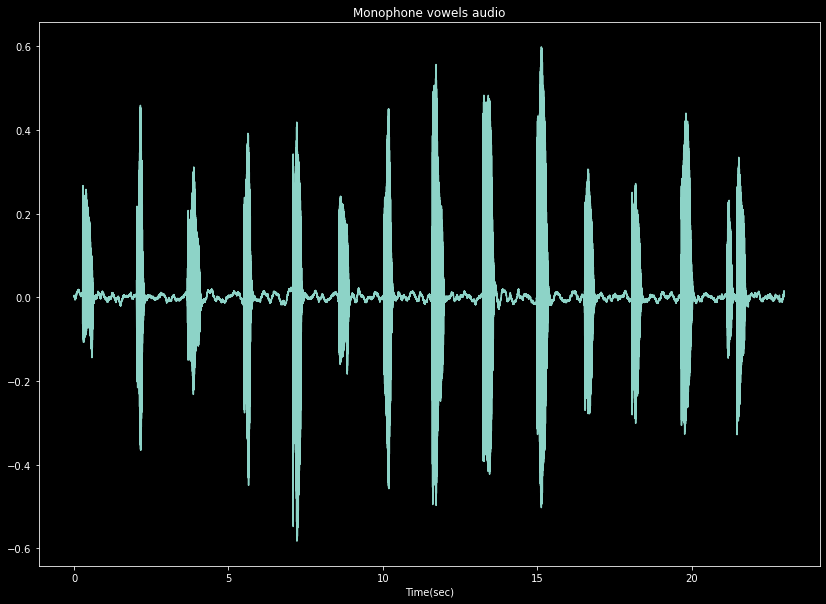

In [4]:
audio, sr = load("Audios\Monophone vowels.wav")
time_arr = np.linspace(start=0,stop=len(audio)/sr, num= len(audio))
#Visualizar datos
print("Sample rate = " + str(sr))
plt.figure(figsize=(14,10))
plt.title("Monophone vowels audio")
plt.xlabel("Time(sec)")
plt.plot(time_arr, audio)
plt.show()

In [5]:
frames = frame(audio, 565, 565, axis=0)
print(frames.shape)
formant_list = []
p1 = []
p2 = []
p3 = []
for buffer in frames:
    windowed_frame = buffer * np.hanning(565)
    formants= GetPeaks(windowed_frame, sr)
    formant_list.append( formants )
    p1.append(formants[0])
    p2.append(formants[1])
    if(len(formants)>2):
        p3.append(formants[2])
    else:
        p3.append(0)

(897, 565)


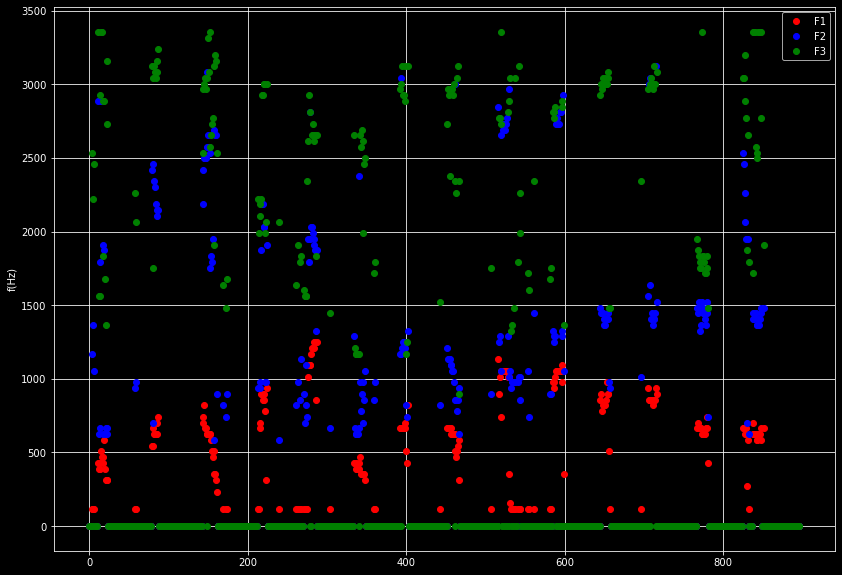

In [6]:
plt.figure(figsize=(14,10))
plt.grid(True)
plt.ylabel("f(Hz)")
plt.plot(p1, "o", color="r", ls='', label="F1")
plt.plot(p2, "o", color = "b", ls='', label = "F2" )
plt.plot(p3, "o", color = "g", ls='', label = "F3" )
plt.legend()
plt.show()

In [7]:
final_vowels_p = []
for F1,F2 in zip(p1, p2):
    final_vowels_p.append(FormantsToVowel(F1,F2,'male'))

In [8]:
class speech_features:
  def __init__(self, is_sound, is_voiced, is_lf, is_sonorant, F1, F2):
    self.is_sound = is_sound
    self.is_voiced = is_voiced
    self.is_lf = is_lf
    self.is_sonorant = is_sonorant
    self.F1 = F1
    self.F2 = F2

In [9]:
images_dict = {
    " ": "silence.jpeg",
    "i": "ee.jpg",
    "y": "i-y.jpg",
    "e": "a-e-i.jpg",
    "ɛ": "a-e-i.jpg",
    "œ": "a-e-i.jpg",
    "a": "a-e-i.jpg",
    "ɶ": "a-e-i.jpg",
    "ɑ": "a-e-i.jpg",
    "ɒ": "a-e-i.jpg",
    "ʌ": "a-e-i.jpg",
    "ɔ": "o.jpg",
    "o": "o.jpg",
    "ɤ": "u.jpg",
    "ø": "u.jpg",
    "w": "u.jpg",
    "u": "u.jpg",
    "tpkc": "finish.jpg",
    "t s": "finish.jpg",
}

In [10]:
# speech_features.is_sound  --> sound/ silence
# speech_feature.is_voiced --> voiced/ unvoiced
# speech_features.is_lf --> low frequency/ high frequency
# speech_feature.sonorant --> sonorant/ vowel
# speech_feature.F1 --> F1
# speech_feature.F2 --> F2

past_status = 'silence'

def classifier(speech_features):
    global past_status
    if speech_features.is_sound:
        if speech_features.is_voiced:
            if speech_features.is_lf:
                if past_status == 'sound':
                    if speech_feature.is_sonorant:
                        past_status = 'sound'
                        return 'mngwrty'
                    else: # vowel
                        past_status = 'sound'
                        return FormantsToVowel(speech_features.F1, speech_features.F2, 'male')
                elif past_status == 'silence':
                    past_status = 'sound'
                    return 'bdg j'              
            else: # hf
                past_status = 'sound'
                return 'vz'
        else: # unvoiced
            if past_status == 'sound':
                past_status = 'sound'
                return 't s'
            elif past_status == 'silence':
                past_status = 'sound'
                return 'tpkc'
    else: # silence
        past_status = 'silence' 
        return ' '

(897, 565)
[12.81179138 33.3106576  66.62131519 87.12018141]
1
Nz: 1
Es: -48.17280001165596
C1: -0.009921646501670529
FirstLPCcoef: (array([0., 0., 0., 0.]), array([12.81179138, 33.3106576 , 66.62131519, 87.12018141]))
Ep: -58.172804354598604


TypeError: unsupported operand type(s) for -: 'tuple' and 'float'

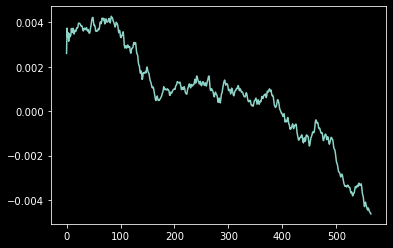

In [11]:
#Parameters
N = 256
new_fs = 1e4
lpc_order = 14
#Tresholds
energy_th = 5e-3
zc_threshold = 20
sonorant_th = 1.5 #Falta definir empiricamente
epsilon = 10e-6
#Window audio
frames = frame(audio, 565, 565, axis=0)
print(frames.shape)
images = []

for buffer in frames:
    is_sound = False # done
    is_voiced = False # done
    is_lf = False # done
    is_sonorant = False
    windowed_frame = buffer * np.hanning(565)
    plt.plot(buffer)
    formants = GetPeaks(windowed_frame, sr)
    F1 = formants[0]
    F2 = formants[1]
    
    #LPC y espectro
    hp_filtered = preemphasis(buffer, coef=1)
    downsampled = resample(hp_filtered, sr, new_fs)
    coefs = lpc(downsampled, lpc_order) #Revisar si son coeficientes del filtro de error o del predictivo
    spectrum = 1/abs(np.fft.rfft(coefs,n=N))
    
    # Sound or Silence
    if windowed_frame < energy_th:
        is_sound = False
    else:
        is_sound = True

    # High Frequency or Low Frequency
    zero_crosses = np.nonzero(np.diff(buffer> 0))[0]
    zero_crosses_count = zero_crosses.size
    if  zero_crosses_count >  zc_threshold:
        is_lf = False
    else:
        is_lf = True
    print(zero_crosses.size)
    
    # Voiced or Unvoiced
    
    # 1. Calculate Zero-crossing count Nz, the number of zero crossing in the block
    Nz = zero_crosses_count
    # 2. Calculate Log energy Es
    Es = 10*np.log10(epsilon+sum(map(lambda x:x*x,buffer))/len(buffer))
    # 3. Normalized autocorrelation coefficient at unit sample delay, C1
    auto_corr_lag_1 = np.correlate(buffer, buffer, mode="full")[1]
    C1 = auto_corr_lag_1/np.sqrt((sum(map(lambda x:x*x,buffer[1:])))*(sum(map(lambda x:x*x,buffer[:-1]))))
    # 4. First LPC coefficient (12 poles)
    FirstLPCcoef = GetFirst12PoleLPCCOef(buffer, sr)
    # 5. Normalized prediction error, Ep, expressed in DB
    sum_exp = 10
    Ep = Es - 10*np.log10(epsilon+sum_exp) # Terminar
    # LINK: https://www.clear.rice.edu/elec532/PROJECTS00/vocode/uv/uvdet.html
    print('Nz:', Nz)
    print('Es:', Es)
    print('C1:', C1)
    print('FirstLPCcoef:', FirstLPCcoef)
    print('Ep:', Ep)
    # Means and Covariance Matrix
    silence_mean = np.array([9.6613, -38.1601, 0.989, 0.5084, -10.8084])
    silence_cov = np.array([[1.0000, 0.6760, -0.7077, -0.1904, 0.7208]
                  ,[0.6760, 1.0000, 0.6933, 0.2918, -0.9425]
                  ,[-0.7077, 0.6933, 1.0000, 0.3275, -0.8426]
                  ,[-0.1904, 0.2918, 0.3275, 1.0000, -0.2122]
                  ,[0.7208, -0.9425, -0.826, -0.2122, 1.0000]])
    
    unvoiced_mean = np.array([10.4286, -36.7536, 0.9598, 0.5243, -10.9076])
    unvoiced_cov = np.array([[1.0000, 0.6059, -0.4069, 0.4648, -0.4603]
                   ,[0.6059, 1.0000, -0.1713, 0.1916, -0.9337]
                   ,[-0.4069, -0.1713, 1.0000, 0.1990, -0.1685]
                   ,[0.4648, 0.1916, 0.1990, 1.0000, -0.2121]
                   ,[-0.4603, -0.9337, -0.1685, -0.2121, 1.0000]])
    
    voiced_mean = np.array([29.1853, -18.3327, 0.9826, 1.1977, -11.1256])
    voiced_cov = np.array([[1.0000, -0.2146, -0.8393, -0.3362, 0.3608]
                 ,[-0.2146, 1.0000, 0.1793, 0.6564, -0.7129]
                 ,[-0.8393, 0.1793, 1.0000, 0.3416, -0.5002]
                 ,[-0.3362, 0.6564, 0.3416, 1.0000, -0.4850]
                 ,[0.3608, -0.7129, -0.5002, -0.4850, 1.0000]])
    
    X = np.array([Nz, Es, C1, FirstLPCcoef, Ep])
    # Calculate distances (di)
    d_silence = np.transpose(X-silence_mean)*np.linalg.inv(silence_cov)*(X-silence_mean)
    d_unvoiced = np.transpose(X-unvoiced_mean)*np.linalg.inv(unvoiced_cov)*(X-unvoiced_mean)
    d_voiced = np.transpose(X-voiced_mean)*np.linalg.inv(voiced_cov)*(X-voiced_mean)
    
    # Choose minimized distance category
    if d_unvoiced < d_voiced:
        is_voiced = True
    else:
        is_voiced = False
        
    # Sonorant or Vowel
    start_indx = int(640*(len(windowed_frame)/sr)) #Start calculation from 640Hz
    end_indx = int(2800*(len(windowed_frame)/sr))  #End calculation at 2800Hz
    low_freq_energy = np.dot(spectrum[start_indx:end_indx], spectrum[start_indx:end_indx]) #Energy
    
    start_indx = int(2000*(len(windowed_frame)/sr)) #Start calculation from 2000Hz
    end_indx = int(3000*(len(windowed_frame)/sr))  #End calculation at 300Hz
    high_freq_energy = np.dot(spectrum[start_indx:end_indx], spectrum[start_indx:end_indx]) #Energy
    
    ratio = high_freq_energy / low_freq_energy
    if ratio > sonorant_th:
        is_sonorant = True
    else:
        is_sonorant = False
    # Decision Tree
    sf = speech_features(is_sound, is_voiced, is_lf, is_sonorant, F1, F2)
    phoneme = classifier(sf)
    image = images_dict[phoneme]
    images.append(image)

plt.show()

In [ ]:
def GetCoefs(buffer, fs, energy_th=5e-3, N=252, new_fs=1e4, lpc_order=14):
    if( buffer.std() < energy_th ):
        return np.zeros(NUMBER_OF_SLOTS) #Descarto el frame si es silencio
    hp_filtered = preemphasis(buffer, coef=1)
    downsampled = resample(hp_filtered, fs, new_fs)
    coefs = lpc(downsampled, lpc_order) #Revisar si son coeficientes del filtro de error o del predictivo
    spectrum = 1/abs(np.fft.rfft(coefs,n=N))
    start_indx = int(150*(len(buffer)/fs)) #Start looking from 150Hz
    end_indx = int(3400*(len(buffer)/fs))  #End search at 3400Hz